# TAP Thermal Simulations

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats.distributions import t as stud_t

from scipy.integrate import odeint
from scipy.optimize import curve_fit

from gradient import thermal_gradient
from numerical_models import one_zone_numerical, three_zone_numerical
from one_zone_analytics import one_zone_analytics

In [2]:
def plot_exit_flow(time, model, figsize=(12, 6)):
    
    plt.figure(figsize=figsize)
    plt.title('Reactor exit flow', fontsize=16)
    plt.plot(time, model)
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Exit flow (mol / s)', fontsize=15)
    plt.tight_layout()
    
    return plt

In [3]:
def compare_to_analytical(time, analytical, model, label, figsize=(12, 6)):
    
    plt.figure(figsize=figsize)
    plt.title('Reactor exit flow', fontsize=16)
    plt.plot(time, analytical, label='analytical model')
    plt.plot(time, one_zone_model, label=label)
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Exit flow (mol / s)', fontsize=15)
    plt.legend(loc='best')
    
    return plt

In [4]:
def plot_temp_gradient(space, gradient, figsize=(12, 6)):
    
    plt.figure(figsize=figsize)
    plt.title('Reactor temperature gradient', fontsize=16)
    plt.plot(space, gradient, 'r--o')
    plt.xlabel('Axial coordinates', fontsize=15)
    plt.ylabel('Temperature (K)', fontsize=15)
    
    return plt

In [5]:
def plot_model_validation(time, *args):
    
    analytical_model = args[0]
    one_zone_model, three_zone_model = args[1], args[2]
    
    plt.figure(figsize=(12, 8))
    plt.title('Model validation')
    plt.plot(time, one_zone_model, label='one zone model')
    plt.plot(time, analytical_model, label='analytical model')
    plt.plot(time, three_zone_model, label='three zone model')
    plt.xlabel('Time (s)', fontsize=15)
    plt.ylabel('Exit flow (mol / s)', fontsize=15)
    plt.legend(loc='best', fontsize=15)
    
    return plt

In [6]:
def student_t_stats(samples, pcov, popt, alpha=0.05):
    
    num_samples = len(samples)
    num_params = len(popt)
    
    deg_of_freedom = max(0, num_samples - num_params)
    
    t_value = stud_t.ppf(1.0 - 0.5 * alpha, deg_of_freedom)
    
    conf_invervals = []
    for var in (np.diag(pcov)):
        sigma = var**0.5
        conf_intervals.append(sigma * t_value) 
        
    return conf_invervals

# Model validation

Reactor config

In [7]:
area = np.pi * (0.00275) ** 2

gridpoints = 1000

space = np.linspace(0, 0.04, gridpoints)
step_size = space[-1] / (gridpoints - 1)

Assuming constant temperature 

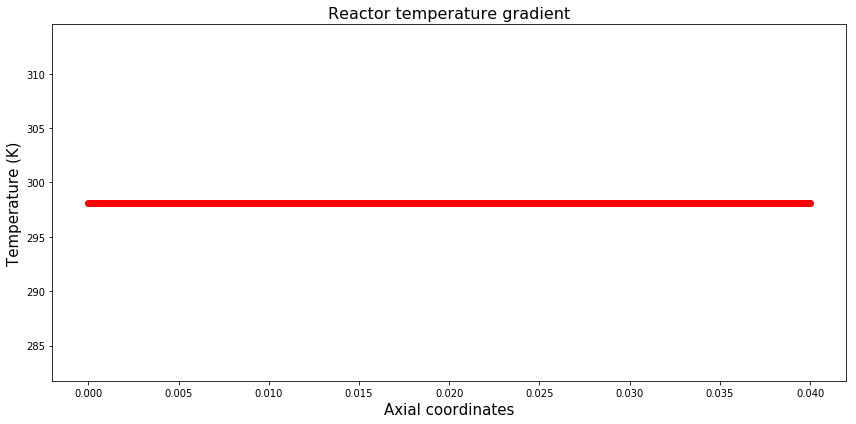

In [8]:
ref_temp = 298.15

temp_measures = [ref_temp, ref_temp]
gradient = thermal_gradient(space, temp_measures)

plot_temp_gradient(space, gradient)
plt.tight_layout()

Model comparison

In [9]:
# Analytical model and one zone reactor setup
ref_coeffs = [5.e-3] * 3
time = np.linspace(0.0, 1.0, 1000)

In [10]:
analytical_model = one_zone_analytics(
    dimensional=True,
    adsorption=False,
    **{
        'time': time,
        'space': space,
        'num_molecules': 1.e-9,
        'eps': 0.4,
        'coeff': ref_coeffs[1]
    }
)

In [11]:
one_zone_model = one_zone_numerical(
    (time, gradient, gridpoints, step_size, area), ref_coeffs[1],
)

/Users/severinlangberg/Desktop/tapThermal/tapThermal/numerical_models.py:38: RuntimeWarning: overflow encountered in exp
  exp = np.clip(np.exp(time / tau), 1.e-12, 1.e12)


In [12]:
# Three zone reactor setup
zones = np.array([0.016, 0.008, 0.016], dtype=float)

grid = np.array(zones * gridpoints, dtype=int)
grid_size = np.sum(grid)

step_size = np.sum(zones) / (grid_size - 1)

space = np.linspace(0, np.sum(zones), grid_size)

gradient = thermal_gradient(space, temp_measures)

In [13]:
three_zone_model = three_zone_numerical(
    (time, gradient, grid, step_size, area), ref_coeffs
)

/Users/severinlangberg/Desktop/tapThermal/tapThermal/numerical_models.py:38: RuntimeWarning: overflow encountered in exp
  exp = np.clip(np.exp(time / tau), 1.e-12, 1.e12)


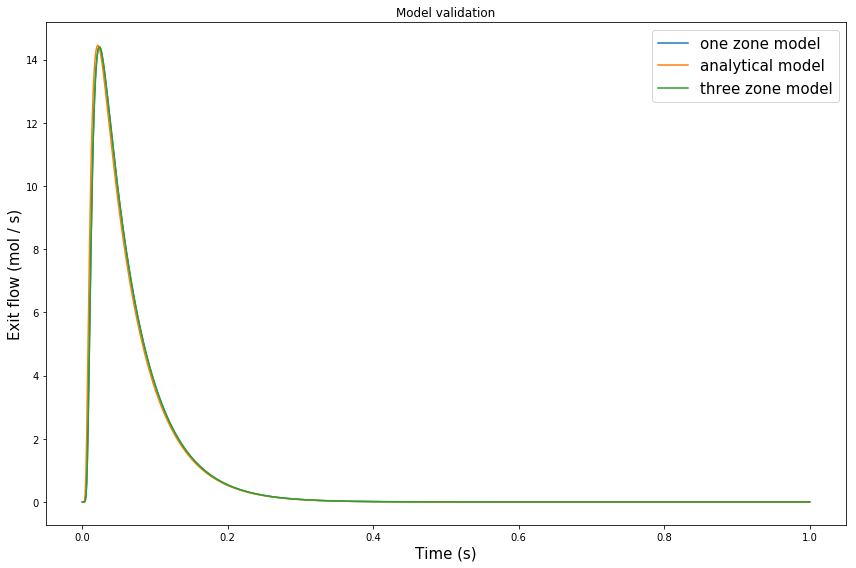

In [14]:
plot_model_validation(time, analytical_model, one_zone_model, three_zone_model)
plt.tight_layout()

# Non-linear least squares approximation to uniform reactor

Experimental setup

In [15]:
gridpoints = 300

space = np.linspace(0, 0.04, gridpoints)
step_size = space[-1] / (gridpoints - 1)

Defining temp gradient

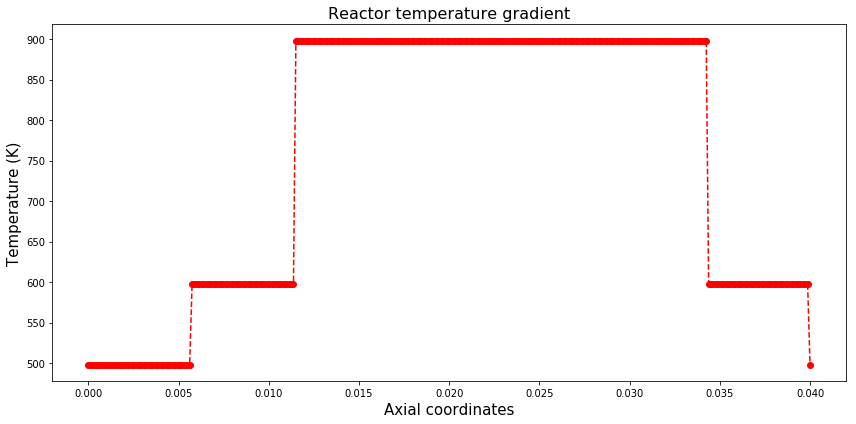

In [16]:
ref_temp = 298.15

temp_measures = [ref_temp + 200, ref_temp + 300,
                 ref_temp + 600, ref_temp + 600,
                 ref_temp + 600, ref_temp + 600,
                 ref_temp + 300, ref_temp + 200]
gradient = thermal_gradient(space, temp_measures)

plot_temp_gradient(space, gradient)
plt.tight_layout()

One zone model with non-constant gradient

In [17]:
one_zone_model = one_zone_numerical(
    (time, gradient, gridpoints, step_size, area), ref_coeffs[1]
)

/Users/severinlangberg/Desktop/tapThermal/tapThermal/numerical_models.py:38: RuntimeWarning: overflow encountered in exp
  exp = np.clip(np.exp(time / tau), 1.e-12, 1.e12)


Comparing to standard curve

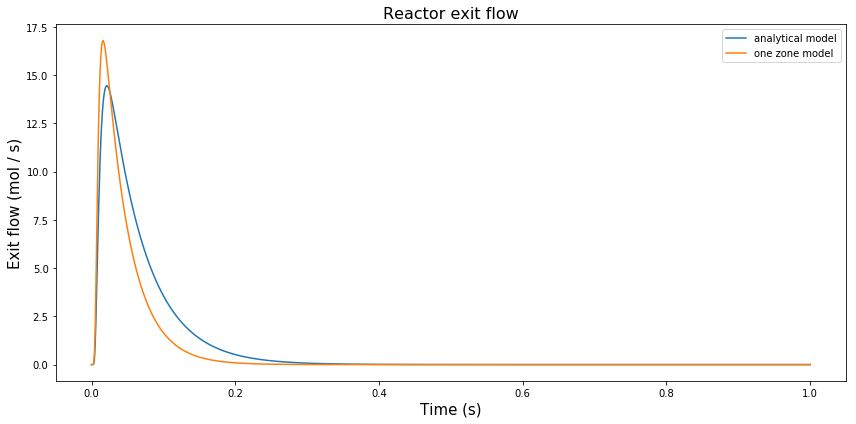

In [18]:
compare_to_analytical(time, analytical_model, one_zone_model, label='one zone model')
plt.tight_layout()

A temp difference of 

In [ ]:
np.max(temp_measures) - np.min(temp_measures)

400.0

Kelvin along the reactor indicates influencing the diffusion process. Estimation of diffusion coefficient

In [ ]:
param_estimate = 4.5e-3

popt, pcov = curve_fit(one_zone_numerical,
                       (time, gradient, gridpoints, step_size, area),
                       one_zone_model, 
                       p0=param_estimate, 
                       method='lm')

print('Estimated diffusion coefficient {} with covaraince {}'.format(popt, pcov))

/Users/severinlangberg/Desktop/tapThermal/tapThermal/numerical_models.py:38: RuntimeWarning: overflow encountered in exp
  exp = np.clip(np.exp(time / tau), 1.e-12, 1.e12)


# Non-linear least squares approximation to three-zone reactor

Experimental setup

In [ ]:
# Three zone reactor setup
zones = np.array([0.016, 0.008, 0.016], dtype=float)

grid = np.array(zones * gridpoints, dtype=int)
grid_size = np.sum(grid)

step_size = np.sum(zones) / (grid_size - 1)

space = np.linspace(0, np.sum(zones), grid_size)

gradient = thermal_gradient(space, temp_measures)

Defining temp gradient

In [ ]:
temp_measures = [ref_temp + 300, ref_temp + 400,
                 ref_temp + 600, ref_temp + 600,
                 ref_temp + 600, ref_temp + 600,
                 ref_temp + 600, ref_temp + 600,
                 ref_temp + 500, ref_temp + 400]
gradient = thermal_gradient(space, temp_measures)

plot_temp_gradient(space, gradient)
plt.tight_layout()

Three zone model with non-constant gradient

In [ ]:
three_zone_model = three_zone_numerical(
    (time, gradient, grid, step_size, area), ref_coeffs
)

which compared to the standard curve

In [ ]:
compare_to_analytical(time, analytical_model, three_zone_model, label='three zone model')
plt.tight_layout()

indicates that a temparature gradient singificantly influences the diffusion process. Estimating diffusion coefficients:

In [ ]:
param_estimate = [4.5e-3] * 3

popt, pcov = curve_fit(three_zone_numerical,
                       (time, gradient, grid, step_size, area),
                       one_zone_model, 
                       p0=param_estimate, 
                       method='lm')

print('Estimated diffusion coefficients {} with covaraince {} respectively'
      ''.format(popt, pcov))